<a href="https://colab.research.google.com/github/Bhuvaneswarij/gitingest/blob/main/Time%20series%20forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna shap yfinance scikit-learn tensorflow keras matplotlib seaborn tqdm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.3 MB/s eta 0:00:00


In [4]:
import shap
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import datetime
import warnings
warnings.filterwarnings("ignore")


In [5]:
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
df = data.copy()
df["Return"] = df["Close"].pct_change()
df["SMA_7"] = df["Close"].rolling(7).mean()
df["SMA_21"] = df["Close"].rolling(21).mean()
df["EMA_9"] = df["Close"].ewm(span=9).mean()
df["Volatility"] = df["Return"].rolling(21).std()
df.dropna(inplace=True)

In [7]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)

In [10]:

SEQ_LEN = 30

def create_sequences(data, seq_len):
    X = []
    y = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][df.columns.get_loc("Close")])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df.values, SEQ_LEN)


In [25]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [26]:
def build_lstm(seq_len, n_features, units=64, dropout=0.2, rec_dropout=0.0, lr=1e-3, weight_decay=1e-6):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.LSTM(units, return_sequences=False, dropout=dropout,
                    recurrent_dropout=rec_dropout,
                    kernel_regularizer=regularizers.l2(weight_decay))(inp)
    x = layers.Dense(max(16, units//4), activation="relu",
                     kernel_regularizer=regularizers.l2(weight_decay))(x)
    out = layers.Dense(1, activation="linear")(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mae"])
    return model


In [28]:
HP = {
    "units": 128,
    "dropout": 0.15,
    "rec_dropout": 0.0,
    "lr": 1e-4,
    "wd": 1e-6,
    "batch_size": 64,
    "epochs": 60
}


In [29]:
final_model = build_lstm(SEQ_LEN, X_train.shape[2],
                         units=HP["units"], dropout=HP["dropout"],
                         rec_dropout=HP["rec_dropout"], lr=HP["lr"],
                         weight_decay=HP["wd"])

In [31]:
ART_DIR = "/content/artifacts"
import os
os.makedirs(ART_DIR, exist_ok=True)


In [32]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
    ModelCheckpoint(os.path.join(ART_DIR,"best_model.h5"), save_best_only=True)
]


In [33]:
history = final_model.fit(X_train, y_train,
                          validation_split=0.1,
                          epochs=HP["epochs"],
                          batch_size=HP["batch_size"],
                          callbacks=callbacks,
                          verbose=1)


Epoch 1/60
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0085 - mae: 0.0628

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0083 - mae: 0.0618 - val_loss: 0.0026 - val_mae: 0.0437 - learning_rate: 1.0000e-04
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 6.8582e-04 - mae: 0.0166 - val_loss: 0.0037 - val_mae: 0.0547 - learning_rate: 1.0000e-04
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 5.1222e-04 - mae: 0.0137 - val_loss: 0.0033 - val_mae: 0.0515 - learning_rate: 1.0000e-04
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.9887e-04 - mae: 0.0139

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 5.9914e-04 - mae: 0.0139 - val_loss: 0.0024 - val_mae: 0.0420 - learning_rate: 1.0000e-04
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 5.7008e-04 - mae: 0.0134 - val_loss: 0.0026 - val_mae: 0.0444 - learning_rate: 1.0000e-04
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 5.9418e-04 - mae: 0.0142 - val_loss: 0.0028 - val_mae: 0.0467 - learning_rate: 1.0000e-04
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 5.5420e-04 - mae: 0.0134 - val_loss: 0.0039 - val_mae: 0.0570 - learning_rate: 1.0000e-04
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 5.0058e-04 - mae: 0.0128 - val_loss: 0.0031 - val_mae: 0.0493 - learning_rate: 1.0000e-04
Epoch 9/60
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.2960e-04 - mae: 0.0128

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 5.2788e-04 - mae: 0.0128 - val_loss: 0.0023 - val_mae: 0.0417 - learning_rate: 1.0000e-04
Epoch 10/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 4.8817e-04 - mae: 0.0122 - val_loss: 0.0048 - val_mae: 0.0640 - learning_rate: 5.0000e-05
Epoch 11/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 4.1742e-04 - mae: 0.0119 - val_loss: 0.0036 - val_mae: 0.0537 - learning_rate: 5.0000e-05
Epoch 12/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 4.0530e-04 - mae: 0.0113 - val_loss: 0.0047 - val_mae: 0.0634 - learning_rate: 5.0000e-05
Epoch 13/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 3.9638e-04 - mae: 0.0111 - val_loss: 0.0030 - val_mae: 0.0483 - learning_rate: 5.0000e-05
Epoch 14/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.9957e-04 - mae: 0.0112 - val_loss: 0.0042 - val_mae: 0.0589 - learning_rate: 5.0000e-05
Epoch 15/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 3.9537e-04 - mae: 0.0105 - val_loss: 0.0044 - val_ma

In [34]:

final_model.save(os.path.join(ART_DIR,"final_model.h5"))
print("Training complete. Model saved.")


Training complete. Model saved.


In [37]:
# Feature engineering
df["return"] = df["Close"].pct_change()
df["ma7"] = df["Close"].rolling(7).mean()
df["ma21"] = df["Close"].rolling(21).mean()
df["ma50"] = df["Close"].rolling(50).mean()
df["vol7"] = df["return"].rolling(7).std()
delta = df["Close"].diff()
up = delta.clip(lower=0).rolling(14).mean()
down = -delta.clip(upper=0).rolling(14).mean()
rs = up / (down + 1e-9)
df["rsi"] = 100 - (100 / (1 + rs))
df["bb_mid"] = df["Close"].rolling(20).mean()
df["bb_std"] = df["Close"].rolling(20).std()
df["bb_width"] = df["bb_std"] / (df["bb_mid"] + 1e-9)
df = df.dropna()


In [38]:
print(df.columns)


MultiIndex([(     'Close', 'AAPL'),
            (      'High', 'AAPL'),
            (       'Low', 'AAPL'),
            (      'Open', 'AAPL'),
            (    'Volume', 'AAPL'),
            (    'Return',     ''),
            (     'SMA_7',     ''),
            (    'SMA_21',     ''),
            (     'EMA_9',     ''),
            ('Volatility',     ''),
            (    'return',     ''),
            (       'ma7',     ''),
            (      'ma21',     ''),
            (      'ma50',     ''),
            (      'vol7',     ''),
            (       'rsi',     ''),
            (    'bb_mid',     ''),
            (    'bb_std',     ''),
            (  'bb_width',     '')],
           names=['Price', 'Ticker'])


In [39]:
FEATURES = ["Close","Volume","return","ma7","ma21","ma50","vol7","rsi","bb_width"]
scaler = StandardScaler()
X_all = scaler.fit_transform(df[FEATURES])
y_all = X_all[:, FEATURES.index("Close")]


In [40]:
pred_scaled = final_model.predict(X_test, verbose=0).reshape(-1)
n_features = X_all.shape[1]
close_idx = FEATURES.index("Close")


In [44]:
dummy_pred = np.zeros((len(pred_scaled), n_features))
dummy_pred[:, close_idx] = pred_scaled
inv_pred = scaler.inverse_transform(dummy_pred)[:, close_idx]

dummy_actual = np.zeros((len(y_test), n_features))
dummy_actual[:, close_idx] = y_test.reshape(-1)
inv_actual = scaler.inverse_transform(dummy_actual)[:, close_idx]


In [45]:
n_features = X_all.shape[1]
close_idx = FEATURES.index("Close")


In [43]:
print("Predictions complete. Shapes -> inv_pred:", inv_pred.shape, "inv_actual:", inv_actual.shape)

Predictions complete. Shapes -> inv_pred: (745,) inv_actual: (745,)


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(inv_actual, inv_pred)
rmse = mean_squared_error(inv_actual, inv_pred) ** 0.5   # take sqrt manually
print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")


MAE: 5.3128 | RMSE: 6.1511


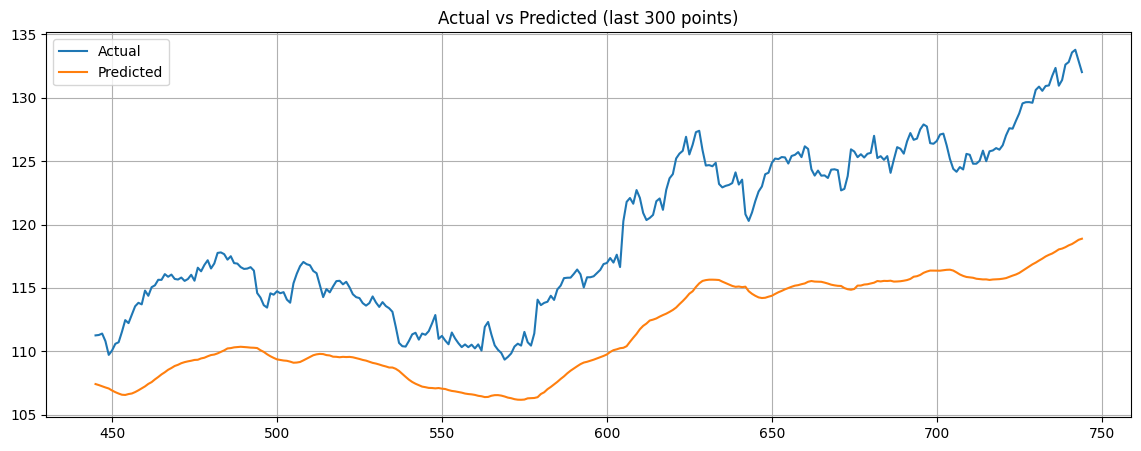

In [55]:
import matplotlib.pyplot as plt
N = min(300, len(inv_actual))  # plot last 300 points
idx = np.arange(len(inv_actual))[-N:]

plt.figure(figsize=(14,5))
plt.plot(idx, inv_actual[-N:], label="Actual")
plt.plot(idx, inv_pred[-N:], label="Predicted")
plt.title("Actual vs Predicted (last {} points)".format(N))
plt.legend()
plt.grid(True)
plt.show()


MC Dropout coverage ~ 0.546


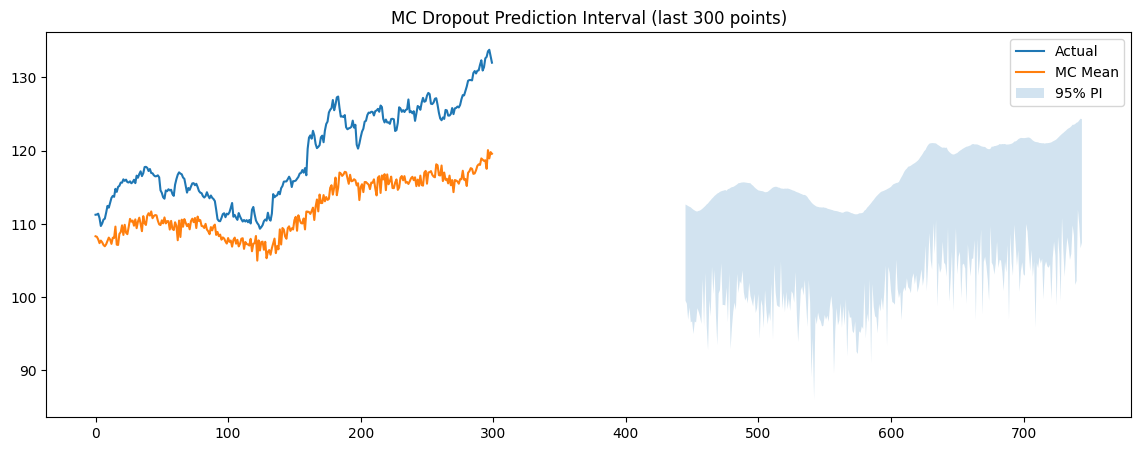

In [56]:
MC_SAMPLES = 50

# MC predict function with dropout active
def mc_predict(model, X, samples=MC_SAMPLES):
    preds = []
    for _ in range(samples):
        preds.append(model(X, training=True).numpy().reshape(-1))
    return np.array(preds)

# mc_model should have same weights as final_model
mc_model = build_lstm(SEQ_LEN, X_train.shape[2],
                      units=HP["units"], dropout=HP["dropout"], rec_dropout=HP["rec_dropout"],
                      lr=HP["lr"], weight_decay=HP["wd"])
mc_model.load_weights(os.path.join(ART_DIR,"best_model.h5"))

mc_preds_scaled = mc_predict(mc_model, X_test, MC_SAMPLES)

# Inverse transform MC predictions
mc_inv = []
for s in range(mc_preds_scaled.shape[0]):
    d = np.zeros((len(mc_preds_scaled[s]), n_features))
    d[:, close_idx] = mc_preds_scaled[s]
    mc_inv.append(scaler.inverse_transform(d)[:, close_idx])
mc_inv = np.array(mc_inv)

# Compute mean + 95% PI
mc_mean = mc_inv.mean(axis=0)
mc_lower = np.percentile(mc_inv, 2.5, axis=0)
mc_upper = np.percentile(mc_inv, 97.5, axis=0)

# Coverage of actuals in prediction interval
coverage = np.mean((inv_actual >= mc_lower) & (inv_actual <= mc_upper))
print(f"MC Dropout coverage ~ {coverage:.3f}")

# Plot MC Dropout intervals
plt.figure(figsize=(14,5))
plt.plot(inv_actual[-N:], label="Actual")
plt.plot(mc_mean[-N:], label="MC Mean")
plt.fill_between(idx, mc_lower[-N:], mc_upper[-N:], alpha=0.2, label="95% PI")
plt.legend()
plt.title("MC Dropout Prediction Interval (last {} points)".format(N))
plt.show()


In [57]:
import shap

# Flatten sequences for Kernel SHAP
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

def model_predict_flat(x_flat):
    x = x_flat.reshape((-1, SEQ_LEN, X_train.shape[2]))
    return final_model.predict(x, verbose=0).reshape(-1)

shap_vals = None
try:
    ge = shap.GradientExplainer((final_model.inputs, final_model.outputs),
                                X_train[:min(len(X_train),100)])
    shap_vals = ge.shap_values(X_test[:min(50, len(X_test))])
    print("Used GradientExplainer")
except:
    try:
        ke = shap.KernelExplainer(model_predict_flat, X_train_flat[:min(len(X_train_flat),100)])
        shap_vals = ke.shap_values(X_test_flat[:min(50, len(X_test_flat))], nsamples=100)
        print("Used KernelExplainer")
    except:
        print("SHAP explanation skipped")

# Save SHAP values
if shap_vals is not None:
    np.save(os.path.join(ART_DIR, "shap_vals.npy"), np.array(shap_vals))
    print("SHAP values saved.")


  0%|          | 0/50 [00:00<?, ?it/s]

Used KernelExplainer
SHAP values saved.


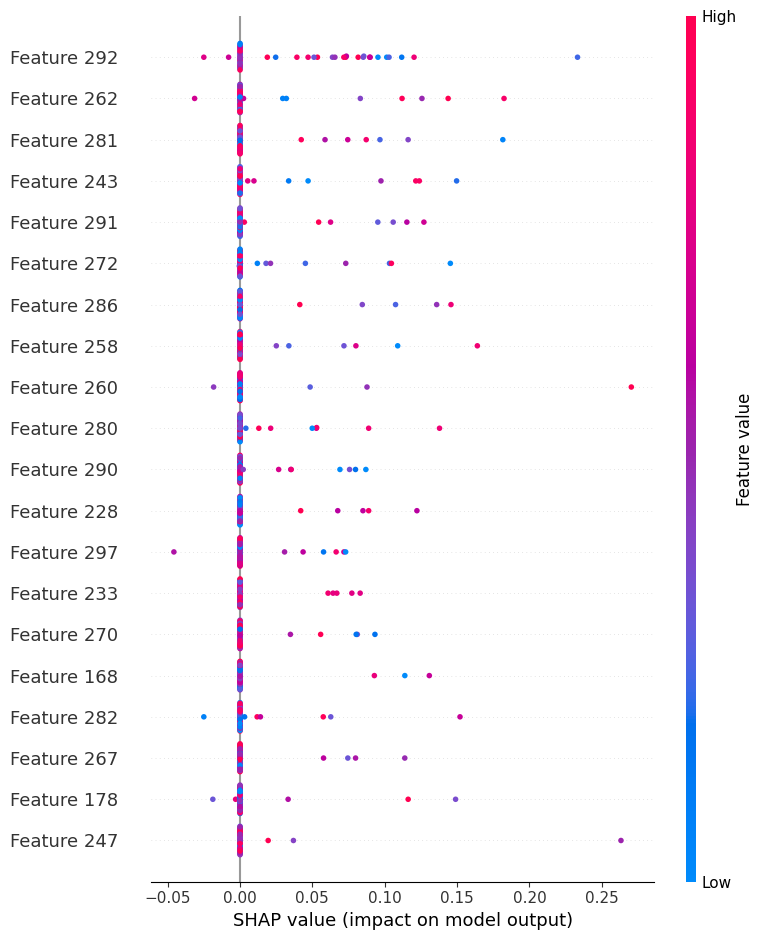

In [58]:
if shap_vals is not None:
    shap.summary_plot(shap_vals, X_test_flat[:min(50,len(X_test_flat))])


In [59]:
MIW = (mc_upper - mc_lower).mean()
print(f"Mean Interval Width (MIW): {MIW:.4f}")


Mean Interval Width (MIW): 14.7841
